# Taller de SMSB

## Análisis de Trayectorias

In [1]:
# Archivos en el directorio de trabajo
!ls

1fin                           analisis
4fkw                           funciones_auxiliares.ipynb
Analisis_de_trayectorias.ipynb trayectorias_DM_cdk2.7z


In [2]:
# Archivos en el directorio de trabajo
!ls 1fin/rep_1/

1_min                         sa_lig_1fin_CS262.rst7
2_term                        sa_lig_1fin_CS262_eq.mdinfo
3_eq                          sa_lig_1fin_CS262_prod.mdinfo
4_prod                        sa_lig_1fin_CS262_term.mdinfo
sa_lig_1fin_CS262.prmtop


## Propiedades del sistema

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, style='ticks')
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [4]:
%run funciones_auxiliares.ipynb

### Minimización

In [5]:
# Path a los archivos .out de minimización de la conf 1fin
min_out_1fin_files = ['1fin/rep_1/1_min/sa_lig_1fin_CS262_min_solv.out', 
                      '1fin/rep_1/1_min/sa_lig_1fin_CS262_min_all.out']

In [6]:
# Es posible cargar cada archivo utilizando la función process_minout
df_min_1fin = [process_MIN_out(file) for file in min_out_1fin_files]
df_min_1fin = pd.concat(df_min_1fin, keys=['solv', 'all'])

# Actualiza el valor de los números de pasos
last_step_solv = df_min_1fin.loc['solv', 'NSTEP'].values[-1]
df_min_1fin.loc['all', 'NSTEP'] =  df_min_1fin.loc['all', 'NSTEP'].values + last_step_solv

df_min_1fin.tail()

NSTEP    ENERGY       RMS     GMAX   NUMBER
all 16  9199.0 -180500.0  0.057199   1.9172  21553.0
    17  9299.0 -180530.0  0.074982   2.9914   4586.0
    18  9399.0 -180550.0  0.206320  29.8120   3351.0
    19  9499.0 -180580.0  0.161020  19.4480   3351.0
    20  9587.0 -180600.0  0.049787   2.4167  18182.0

#### Visualización de la energía del sistema

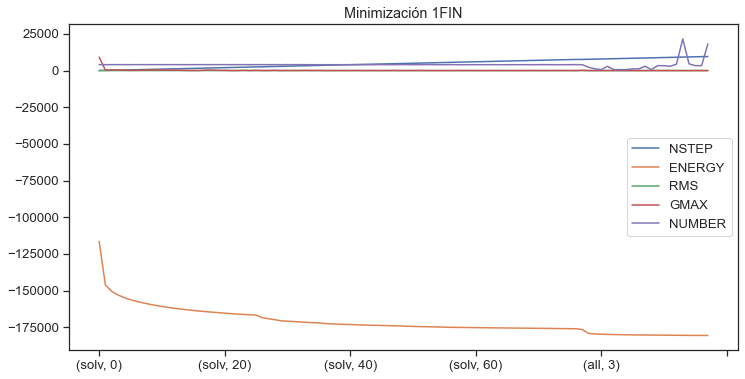

In [7]:
df_min_1fin.plot(title='Minimización 1FIN')
plt.show()

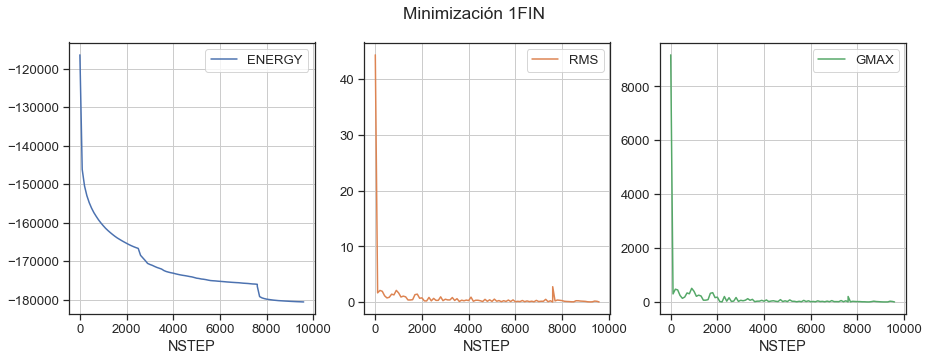

In [8]:
df_min_1fin[['NSTEP', 'ENERGY', 'RMS', 'GMAX']].\
    plot(x='NSTEP', title='Minimización 1FIN', subplots=True, 
         layout=(1, 3), figsize=(15, 5), grid=True)
plt.show()

In [9]:
# Compara el resultado con lo solicitado en el archivo de configuración
!cat 1fin/rep_1/1_min/min_all.in

Minimize all atoms, minimizacion del solvente
   System minimization:
&cntrl
   imin=1,
   ntmin=1,     ! metodo de minimizacion, 1 steepest decent to onjugate gradients
   nmropt=0,    ! no hacer el análisi NMR
   drms=0.05,    ! criterio de convergencia para el gradiente de energía
   maxcyc=50000, ! maximo numero de ciclos para la minimizacion
   ncyc=2500,   ! cuando ntmin=NCYC, indica el paso para cambiar de SD a CG
   ntx=1,       ! #para leerlas coordenadas iniciales, vel y boxsize del inpcrd. 1=para comenzar
   irest=0,     ! #Flag para reiniciar una simulacion; 0= no reiniciar 
   ntpr=100,    ! Intervalo de pasos para gardar informacion
   ntwr=100,    ! Intervalo de pasos para guardar un restart
   iwrap=0,     ! cuando =1, realiza un wrap en favor de la visualizacion de las mol dentro del box, no tiene efecto sobre la dinamica
   ntf=1,       ! Tipo de evaluacion de fuerzas, =1 calcula la interaccion total
   ntb=1,       ! Controla el tipo de simulacion y el PME; =1 NVT =2

### Fases de la dinámica

Carga de los archivos `.out`

In [10]:
dm_outs_1fin = [
    '1fin/rep_1/2_term/sa_lig_1fin_CS262_term.out',
    '1fin/rep_1/3_eq/sa_lig_1fin_CS262_eq.out',
    '1fin/rep_1/4_prod/sa_lig_1fin_CS262_prod.out'
]

df_md_1fin = pd.concat([process_MD_out(file) 
                        for file in dm_outs_1fin],
                        keys=('heat', 'eq', 'prod'))
df_md_1fin.columns

Index(['NSTEP', 'TIME', 'TEMP', 'PRESS', 'Etot', 'EKtot', 'EPtot', 'EELEC',
       'VDWAALS'],
      dtype='object')

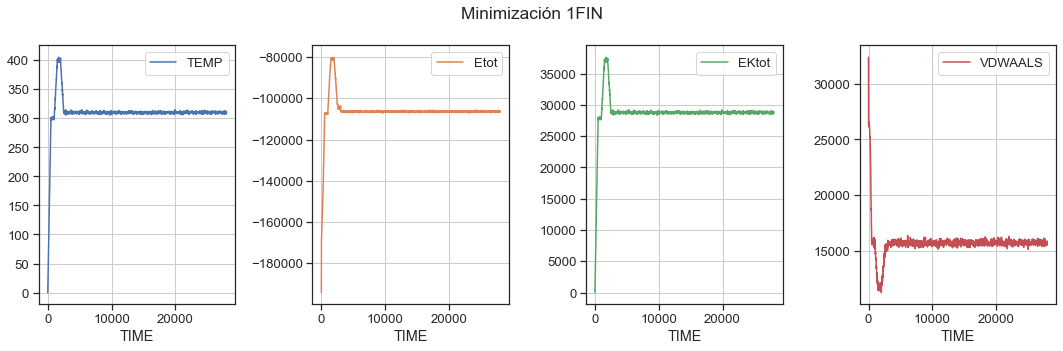

In [11]:

df_md_1fin[['TIME', 'TEMP', 'Etot', 'EKtot', 'VDWAALS']].\
    plot(x='TIME', title='Minimización 1FIN', subplots=True, 
         layout=(1, 4), figsize=(15, 5), grid=True)
plt.tight_layout()
plt.show()

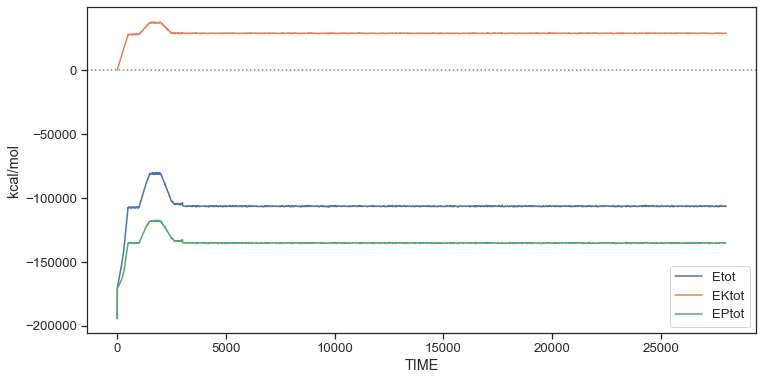

In [12]:
df_md_1fin[['TIME', 'Etot', 'EKtot', 'EPtot']]\
    .plot(x='TIME', ylabel='kcal/mol')
plt.axhline(0, c='gray', linestyle=':')
plt.show()

## Análisis de Trayectorias

In [13]:
import mdtraj as md
import pytraj as pyt

### Carga de la trayectoria
##### Estructura inicial del sistema
Cargamos la estructura inicial del sistema **1fin**, representado por los archivos:
  1. `sa_lig_1fin_CS262.rst7`
  2. `sa_lig_1fin_CS262.prmtop`

In [14]:
conf_inicial_1fin = pyt.load('1fin/rep_1/sa_lig_1fin_CS262.rst7',
                            top='1fin/rep_1/sa_lig_1fin_CS262.prmtop'
                            )
conf_inicial_1fin

pytraj.Trajectory, 1 frames: 
Size: 0.001017 (GB)
<Topology: 45482 atoms, 13830 residues, 13533 mols, PBC with box type = truncoct>
           

##### Trayectoria de la fase de producción

Carga del la trayectoria del sistema (fase de producción), almacenada en el archivo `sa_lig_1fin_CS262_prod.nc`.

In [15]:
traj_prod_1fin = pyt.load('1fin/rep_1/4_prod/sa_lig_1fin_CS262_prod.nc',
         top = '1fin/rep_1/sa_lig_1fin_CS262.prmtop'
        )

# El comando autoimage permite visualizar correctamente el sistema
traj_prod_1fin = traj_prod_1fin.autoimage()

### Visualización

#### Selección de los residuos de la cavidad

Usaremos la librería `get_pocket_residues` del la libreta `funciones_auxiliares` para obtener los residuos que pertenecen al *pocket* de la proteína.

In [16]:
import nglview as ng
# Superponer la trayectoria antes de visualizarla
traj_prod_1fin.superpose(f'@CA')
pocket_residues = '8, 9, 33, 64, 65, 79, 86, 88, 89, 90, 132, 145, 146'
pocket = traj_prod_1fin[f':{pocket_residues}']

view = ng.show_pytraj(traj_prod_1fin)
view.clear()
view.add_representation('cartoon', 'protein')
view.add_representation('licorice', 'LIG')
view.add_trajectory(pocket)
# view.add_representation('line', opacity=0.5)
view

NGLWidget(max_frame=999)

## Calculo de RMSD

Permite comparar 2 conformaciones de la misma molécula.

$$\begin{aligned}
RMSD(W, \hat W) & = RMSE  \\
& = \sqrt{\frac{SSE}{n}} \\
& = \sqrt{\frac{\sum_{i=1}^n (w_i - \hat w_i)^2}{n}} \\
& = \sqrt{\frac{1}{n}\sum_{i=1}^n ((w_{ix} - \hat w_{ix})^2 + (w_{iy} - \hat w_{iy})^2 + (w_{iz} - \hat w_{iz})^2)}
\end{aligned}
$$

donde:
- $RMSD$: *Root Mean Square Deviation* -> Raiz de la media del cuadrado de las "desviaciones"
- $\hat W$: Conformación de referencia (matriz de coordenadas: dims = $n\times3$)
- $w_i$: Vector de posiciones $x,y,z$ del átomo $i$
- $n$: Número de átomos
- $SSE$: *Sum of Squared Errors*

### Compara dos conformaciones con el RMSD

In [17]:
# Carga la conformacion inicial del pdbid 4fkw
conf_inicial_4fkw = pyt.load('4fkw/rep_1/cdk2_LIG.rst7',
                            top='4fkw/rep_1/cdk2_LIG.prmtop')
conf_inicial_4fkw

pytraj.Trajectory, 1 frames: 
Size: 0.000966 (GB)
<Topology: 43221 atoms, 13077 residues, 12780 mols, PBC with box type = truncoct>
           

#### Cálcula tú mismo el RMSD entre dos conformaciones
1. Los sistemas a comparar deben tener el mismo tipo de átomos.

In [18]:
# Selecciona sólo los carbonos alfa de las dos conformaciones
ca_init_1fin = conf_inicial_1fin['@CA'] 
ca_init_4fkw = conf_inicial_4fkw['@CA'] 
ca_init_4fkw # La proteína tiene 298 residuos, por lo tanto 298 CA

pytraj.Trajectory, 1 frames: 
Size: 0.000007 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           

2. Obtención de las coordenadas de los átomos

In [19]:
W_1 = ca_init_1fin[0].xyz # El índice 0 extrae la conformación 0 (la única) 
W_2 = ca_init_4fkw[0].xyz # El índice 0 extrae la conformación 0 (la única) 

W_1.shape # Dimensiones de la matriz de coordenadas

(298, 3)

3. Cálculo, paso a paso del RMSD entre las conformaciones $W_1$ y $W_2$.

In [20]:
# Cálculo de n = numero de CA de la proteína
n = len(ca_init_1fin[0].xyz)

# Cálculo de las diferencias (distancias por atomo entre W_1 y W_1)
W_1 - W_2

# Eleva al cuadrado las diferencias
(W_1 - W_2)**2

# Suma el cuadrado de las diferencias (por coord y por átomo)
np.sum( (W_1 - W_2)**2 )

# Divide entre el número de átomos
np.sum( (W_1 - W_2)**2 ) / n

# Saca la raiz cuadrada
np.sqrt( np.sum( (W_1 - W_2)**2 ) / n )

27.47909632061001

#### Cálcula el RMSD usando `pytraj`

Ya no es necesario pasar directamente las cordenadas, sino los objetos "Trayectory"

In [21]:
?pyt.rmsd

In [22]:
pyt.rmsd(traj = ca_init_1fin, 
         ref = ca_init_4fkw, 
         nofit = True) 
# con no fit evitamos que superponga las estructuras, 
# más adelante sí será necesario hacerlo

array([27.47909632])

### RMSD de la trayectoria ( `1fin`) vs a una estructura de referencia

#### RMSD de la proteína

Implica calcular el RMSD de cada una de las conformaciones (frames) de la trayectoria contra una conformación de referencia en común.

In [23]:
# Cálculo teniendo como referencia la conformación inicial
# de la proteína (antes de la fase de minimización)
rmsd_1 = pyt.rmsd(
            traj = traj_prod_1fin, 
            mask ='@CA',
            ref = conf_inicial_1fin,
            ref_mask = '@CA',
            nofit = False,
            mass = True
        )

In [24]:
# Usando como referencia la primer conformación de la fase de producción
rmsd_2 = pyt.rmsd(
            traj = traj_prod_1fin, 
            mask = '@CA',
            ref = 0,
            ref_mask = '@CA',
            nofit = False,
            mass = True
        )

In [25]:
# rmsd_1 es un vector con los valores de RMSD de cada conformación 
print(len(rmsd_1))
rmsd_1

1000


array([1.66364801, 1.45756748, 1.34946426, ..., 1.86435219, 1.99252687,
       1.81671286])

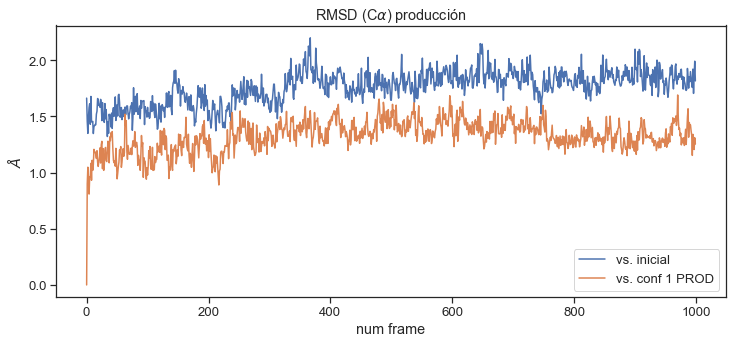

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_1, label='vs. inicial')
ax.plot(rmsd_2, label='vs. conf 1 PROD')
ax.set(title=r'RMSD (C$\alpha$) producción', xlabel='num frame', ylabel=r'$\AA$')
ax.legend()
plt.show()

#### RMSD del ligando y la proteína

In [27]:
traj_prod_1fin.superpose('@CA')
rmsd_lig_1fin = pyt.rmsd(traj = traj_prod_1fin, 
                    ref = 0, 
                    nofit = True, 
                    # Evitamos el fit puesto que ya se ha hecho con .superpose
                    mask = ':LIG')

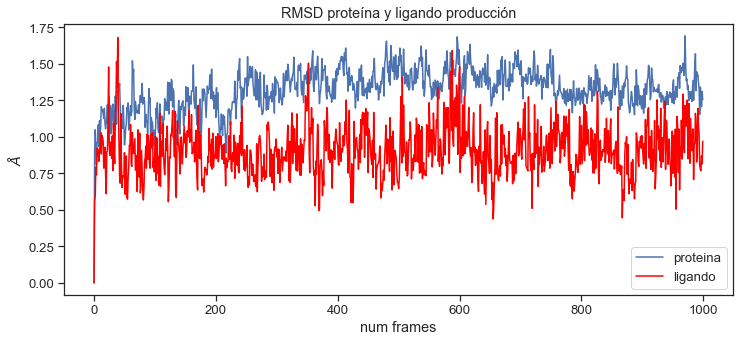

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_2, label='proteina')
ax.plot(rmsd_lig_1fin, label='ligando', color='red')
ax.set(title='RMSD proteína y ligando producción', 
       xlabel='num frames', ylabel=r'$\AA$')
plt.legend()
plt.show()

#### RMSD del ligando y la proteína

In [29]:
# Cálculo del RMSD usando únicamente los átomos de la cavidad de la
# traj_prod_1fin.superpose(f'(@CA)&:{pocket_residues}')
rmsd_pocket = pyt.rmsd(
                traj = traj_prod_1fin, 
                ref = 0, 
                mask = f':{pocket_residues}&@CA'
            )

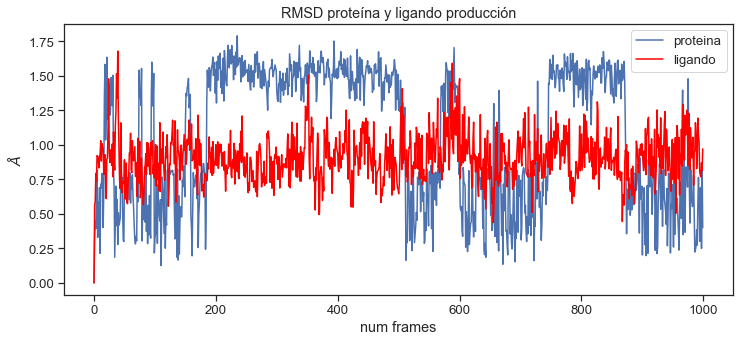

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_pocket, label='proteina')
ax.plot(rmsd_lig_1fin, label='ligando', color='red')
ax.set(title='RMSD proteína y ligando producción', 
       xlabel='num frames', ylabel=r'$\AA$')
plt.legend()
plt.show()

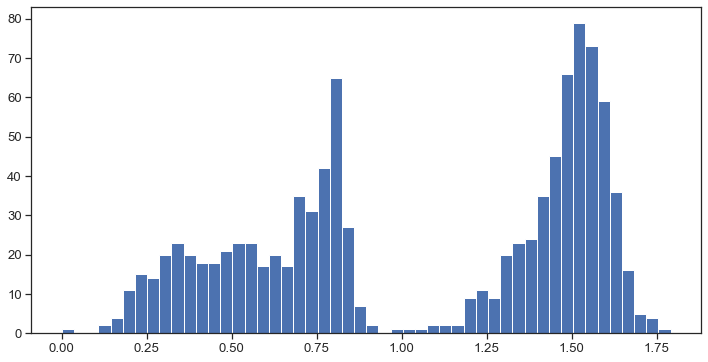

In [31]:
plt.hist(rmsd_pocket, bins=50)
plt.show()

### RMSD por pares de conformaciones

In [32]:
%%time
rmsd_pairwise_1fin = pyt.pairwise_rmsd(
    traj=traj_prod_1fin,
    mask=f'@CA,CB,CD',
    metric='rms'
)

CPU times: user 3.9 s, sys: 27.9 ms, total: 3.93 s
Wall time: 3.92 s


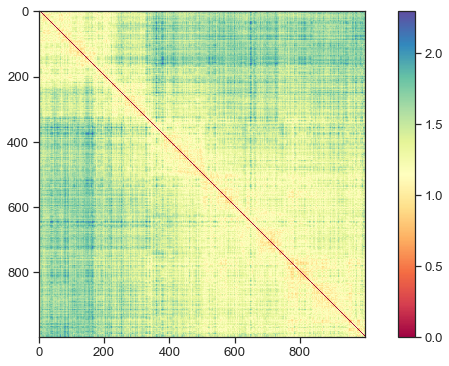

In [33]:
plt.imshow(rmsd_pairwise_1fin, cmap='Spectral', 
           interpolation='nearest')
plt.colorbar()
plt.show()

## RMSF

Es equivalente a la desviación estándar de la posición de un átomo $i$ con respecto a la media  de su posición ($\bar w^{(i)}$) en toda la trayectoria (compuesta por $T$ frames - conformaciones). 

$$\begin{aligned}
RMSF^{(i)} & = \sqrt{\frac{1}{T}\sum_{i=1}^T (w_j^{(i)} - \bar w^{(i)})^2} 
\end{aligned}
$$

donde:
- $RMSF^{(i)}$: *Root Mean Square Fluctuation* del átomo $i$ -> Raiz de la media del cuadrado de las "fluctuaciones"
- $w_j^{(i)}$: Vector de posiciones $x,y,z$ del átomo $i$ en el frame $j$
- $\bar w^{(i)}$: Vector con la media de las posiciones $x,y,z$ del átomo $i$ en toda la trayectoria.
- $T$: Número de frames de la trayectoria


##### Cálculo "Manual" del RMSF

In [34]:
# Extrae las coordenadas de los carbonos alfa de toda la trayectoria
ca_traj_1fin_coords = traj_prod_1fin['@CA'].xyz
# Visualiza las dimensiones de la matriz
ca_traj_1fin_coords.shape

# Calcula T: Primera dimension del arreglo
T = ca_traj_1fin_coords.shape[0]

# Todo el proceso junto (examinalo de adrentro hacia afuera)

# Raiz cuadrada
np.sqrt(
    # Suma entre todas los frames
    np.sum(
        # Suma de los tres ejes
        np.sum(
            # Cuadrado de las diferencias con respecto a la media
            ( ca_traj_1fin_coords - ca_traj_1fin_coords.mean(axis=0) )**2, 
        axis=0),
     axis=1) / T # Divide entre el número de frames
)

array([ 9.50394435,  7.85590388,  7.61319066, ..., 10.89405219,
       10.06889762,  8.58626174])

#### RMSF con pytraj

In [35]:
traj_prod_1fin.superpose('@CA')
rmsf_ca_prot_1fin = pyt.rmsf(traj=traj_prod_1fin, mask='@CA')

# Hay tantos valores de RMSF como C-alfa tiene la proteína
len(rmsf_ca_prot_1fin)

298

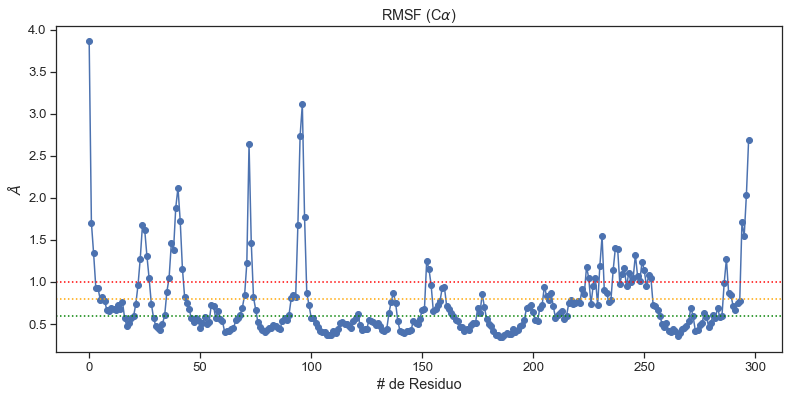

In [36]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(rmsf_ca_prot_1fin[:,1], 'o-')
ax.set(title=r'RMSF (C$\alpha$)', ylabel=r'$\AA$', xlabel='# de Residuo')
ax.axhline(y=0.6, color='green', linestyle=':')
ax.axhline(y=0.8, color='orange', linestyle=':')
ax.axhline(y=1, color='red', linestyle=':')
plt.show()

In [37]:
res_rmsf_up_05 = (np.where(rmsf_ca_prot_1fin[:,1] > .6)[0] + 1).tolist()
res_rmsf_up_08 = (np.where(rmsf_ca_prot_1fin[:,1] > 0.8)[0] + 1).tolist()
res_rmsf_up_1 = (np.where(rmsf_ca_prot_1fin[:,1] > 1.)[0] + 1).tolist()

#### Visualiza los residuos con mayor valor de RMSF

In [38]:
traj_prod_1fin.superpose(f'@CA')
# Conser
view = ng.show_pytraj(traj_prod_1fin['!(:WAT)'])
view.clear()
view.center()
view.add_representation('licorice', 'LIG')
view.add_cartoon(selection='protein', color='blue')
view.add_cartoon(selection='%s' % res_rmsf_up_05, color='green')
view.add_cartoon(selection='%s' % res_rmsf_up_08, color='orange')
view.add_cartoon(selection='%s' % res_rmsf_up_1, color='red')
view

NGLWidget(max_frame=999)

### RMSF: Compara 1fin vs 4fkw

Cargar los datos de la simulación `4fkw`.

In [39]:
# Carga la trayectoria de la proteína 4fkw
traj_prod_4fkw = pyt.load('4fkw/rep_1/4_prod/cdk2_LIG_prod.nc',
         top = '4fkw/rep_1/cdk2_LIG.prmtop'
        )
traj_prod_4fkw = traj_prod_4fkw.autoimage()

Calcula el RMSF de la trayectoria 4fkw.

In [40]:
traj_prod_4fkw.superpose('@CA')
rmsf_ca_prot_4fkw = pyt.rmsf(traj=traj_prod_4fkw, mask='@CA')

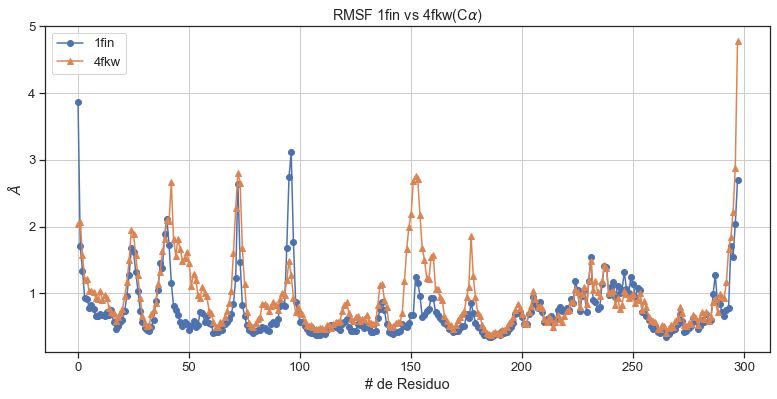

In [41]:
fig, ax = plt.subplots(figsize=(13, 6))
# Sistema 1fin
ax.plot(rmsf_ca_prot_1fin[:,1], 'o-', label='1fin')
# Sistema 4fkw 
ax.plot(rmsf_ca_prot_4fkw[:,1], '^-', label='4fkw')
ax.set(title=r'RMSF 1fin vs 4fkw(C$\alpha$)', 
       ylabel=r'$\AA$', xlabel='# de Residuo')
ax.legend()
ax.grid()
plt.show()

## Distancia entre centros de masa (cavidad vs ligando)

Consiste en calcular el centro de masa de los átomos de las dos moléculas en cuestion. Para este caso, calcularemos el centro de masa de los residuos de la cavidad de la proteína, así como el centro de masa de la molécula. Finalmente, sólo será necesario calcular la distancia entre ambos centros de masa.

In [42]:
mask_prot = f':{pocket_residues}'
# mask_prot = f'@CA'

In [43]:
# Protein 1fin
traj_prod_1fin.superpose(mask_prot)
cmass_pk_1fin = pyt.center_of_mass(traj=traj_prod_1fin, mask=mask_prot)
# Ligando (1fin)
cmas_lig_1fin = pyt.center_of_mass(traj=traj_prod_1fin, mask=':LIG')
# distancia
dist_pk_lig_1fin = np.sqrt(((cmass_pk_1fin - cmas_lig_1fin)**2).sum(axis=1))

In [44]:
# Protein 4fkw
traj_prod_4fkw.superpose(mask_prot)
cmass_pk_4fkw = pyt.center_of_mass(traj=traj_prod_4fkw, mask=mask_prot)
# Ligando (4fkw)
cmas_lig_4fkw = pyt.center_of_mass(traj=traj_prod_4fkw, mask=':LIG')
# distancia
dist_pk_lig_4fkw = np.sqrt(((cmass_pk_4fkw - cmas_lig_4fkw)**2).sum(axis=1))

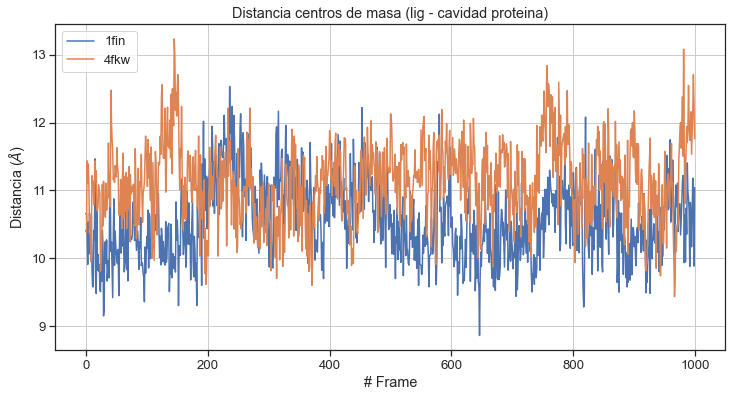

In [45]:
fig, ax = plt.subplots()
ax.plot(dist_pk_lig_1fin, label='1fin')
ax.plot(dist_pk_lig_4fkw, label='4fkw')
ax.set(title='Distancia centros de masa (lig - cavidad proteina)',
      xlabel='# Frame', ylabel=r'Distancia ($\AA$)')
ax.legend()
ax.grid()
plt.show()

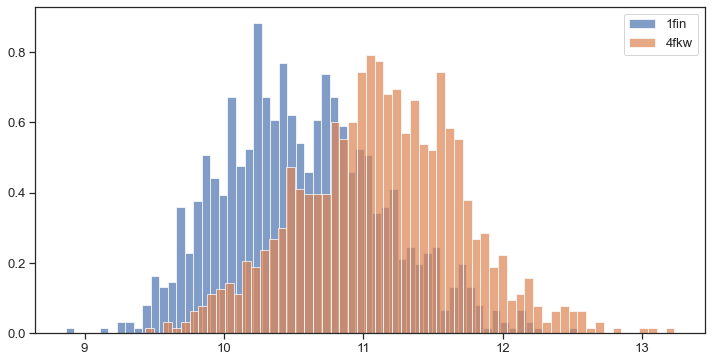

In [46]:
fig, ax = plt.subplots()
ax.hist(dist_pk_lig_1fin, bins=60, alpha=0.7, density=True, label='1fin')
ax.hist(dist_pk_lig_4fkw, bins=60, alpha=0.7, density=True, label='4fkw')
ax.legend()

## Radio de giro


$$Rg = \sqrt{\frac{\sum_{i=1}^n m_i r_i^2}{\sum_{i=1}^n m_i}}$$

donde:
- $n$: número de átomos
- $m_i$: masa del átomo $i$
- $r_i$: distancia del átomo $i$ al centro de masa de todos los átomos conciderados

### Cálculo y gráfica de resultados

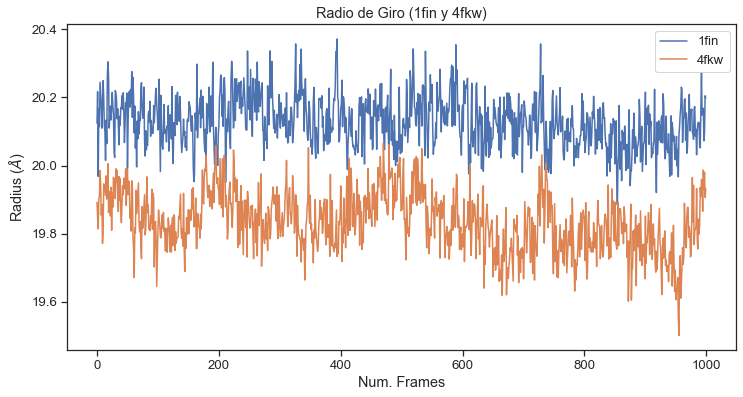

In [47]:
mask_rg = '@CA'
rg_1fin = pyt.radgyr(traj=traj_prod_1fin, mask=mask_rg)
rg_4fkw = pyt.radgyr(traj=traj_prod_4fkw, mask=mask_rg)

# Gráfica de resultados
fig, ax = plt.subplots()
ax.plot(rg_1fin, label='1fin')
ax.plot(rg_4fkw, label='4fkw')
ax.set(title='Radio de Giro (1fin y 4fkw)', 
       xlabel='Num. Frames', ylabel=r'Radius ($\AA$)')
# plt.ylim(0,21)
plt.legend()
plt.show()

## Enlaces de hidrógeno 

Calculo de los enlaces de hidrógeno durante la trayectoria.

In [48]:
# Calculamos todos los enlaces de hidrógeno sin tomar en cuenta el solvente
hb_1fin = pyt.search_hbonds(traj=traj_prod_1fin['!(:WAT)'])
hb_4fkw = pyt.search_hbonds(traj=traj_prod_4fkw['!(:WAT)'])

# Conservamos el diccionario con los enlaces encontrados durante la trayectoria
hb_results_1fin = hb_1fin.to_dict()
hb_results_4fkw = hb_4fkw.to_dict()

### Enlaces de hidrógeno entre la proteína y la molécula

- Convertimos a una tabla de resultados

In [49]:
df_hb_1fin = pd.DataFrame(hb_results_1fin).T
df_hb_1fin = df_hb_1fin[df_hb_1fin.index.str.contains('LIG')]
df_hb_1fin.shape

(22, 1000)

In [50]:
df_hb_4fkw = pd.DataFrame(hb_results_4fkw).T
df_hb_4fkw = df_hb_4fkw[df_hb_4fkw.index.str.contains('LIG')]
df_hb_4fkw.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
LIG299_OAD-LYS33_NZ-HZ3,1,0,0,0,0,1,0,1,0,0,...,0,1,1,0,0,1,0,0,0,0
LIG299_OAE-LEU83_N-H,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,1,1,0,0,1,1
LIG299_OAD-LYS33_NZ-HZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
LIG299_OAD-LYS33_NZ-HZ1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ASP86_OD2-LIG299_N3-H32,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,1,1,1,1,1


Cada valor indica qué residuos están interactuando, en este caso el residuo `LIG` hace referencia a la molécula. El otro término corresponde a algún residuo de la proteína.
- El primer término corresponde al **donador**
- El segundo término corresponde al **aceptor**

#### Cálculo del número de H-bond Prot-Lig durante la trayectoria

In [51]:
# Cálculo del número de HB PL durante la trayectoria (suma por filas)
num_per_frame_1fin = df_hb_1fin.sum(axis=0)
num_per_frame_4fkw = df_hb_4fkw.sum(axis=0)

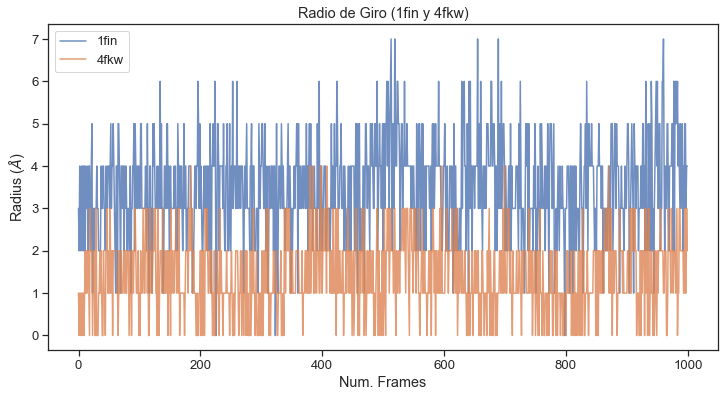

In [52]:
fig, ax = plt.subplots()
ax.plot(num_per_frame_1fin, label='1fin', alpha=0.8)
ax.plot(num_per_frame_4fkw, label='4fkw', alpha=0.8)
ax.set(title='Radio de Giro (1fin y 4fkw)', 
       xlabel='Num. Frames', ylabel=r'Radius ($\AA$)')
plt.legend()
plt.show()

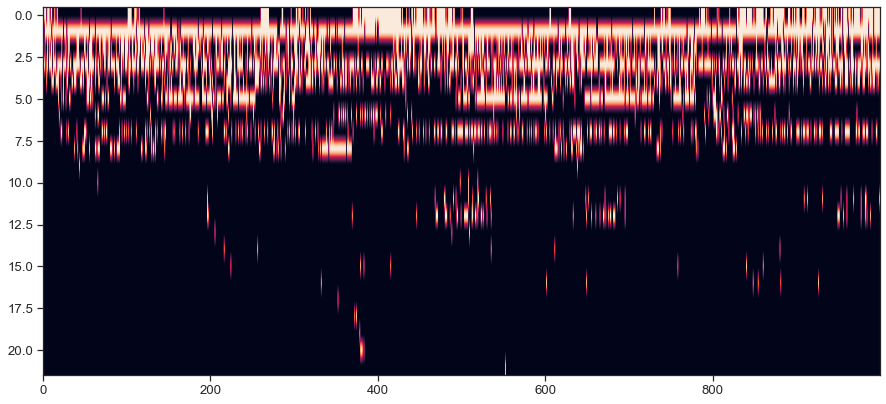

In [53]:
plt.figure(figsize=(15,12))
plt.imshow(df_hb_1fin, aspect=20)
plt.show()

#### Identifica los Hb más frequentes

In [54]:
# Ahora sumamos por columnas
num_per_HB_1fin = df_hb_1fin.sum(axis=1)
num_per_HB_4fkw = df_hb_4fkw.sum(axis=1)

In [55]:
# Muestra los enlaces y su frecuencia en la trayectoria
num_per_HB_1fin.sort_values(ascending=False)

LIG299_OAE-LEU83_N-H         925
GLU81_O-LIG299_N5-HN5        659
ASP86_OD1-LIG299_N3-HHN3     381
LEU83_O-LIG299_N2-HN2        330
LIG299_OAD-LYS33_NZ-HZ2      319
LIG299_OAD-LYS33_NZ-HZ3      302
LIG299_N3-ASP86_N-H          288
LIG299_OAD-LYS33_NZ-HZ1      109
ASP86_OD2-LIG299_N3-HHN3      80
GLN85_OE1-LIG299_N3-HN3       53
LIG299_OAG-GLN85_NE2-HE21     28
LIG299_N3-GLN85_NE2-HE22       7
LIG299_OAE-LIG299_N2-HN2       7
LIG299_OAG-LYS89_NZ-HZ1        5
LIG299_OAG-LYS89_NZ-HZ2        4
LIG299_OAF-LYS89_NZ-HZ2        4
LIG299_OAG-LYS89_NZ-HZ3        3
LIG299_OAD-ASP145_N-H          2
LIG299_OAF-LYS89_NZ-HZ3        2
HIE84_O-LIG299_N3-HN3          1
LIG299_OAF-LYS89_NZ-HZ1        1
ASP86_OD1-LIG299_N3-HN3        1
dtype: int64

In [56]:
num_per_HB_4fkw.sort_values(ascending=False)

LIG299_OAE-LEU83_N-H         408
LIG299_OAD-LYS33_NZ-HZ2      185
LIG299_OAD-LYS33_NZ-HZ1      181
ILE10_O-LIG299_N3-H32        175
LIG299_OAD-LYS33_NZ-HZ3      165
LIG299_OAG-LYS89_NZ-HZ1       49
LIG299_OAG-LYS89_NZ-HZ3       48
LIG299_OAG-LYS89_NZ-HZ2       46
ILE10_O-LIG299_N3-H31         30
ASP86_OD2-LIG299_N3-H32       18
LIG299_OAF-LYS89_NZ-HZ1       18
LIG299_OAF-LYS89_NZ-HZ2       17
LIG299_OAF-LYS89_NZ-HZ3       17
LIG299_OAF-GLN85_NE2-HE21     11
LIG299_OAG-GLN85_NE2-HE22     10
LIG299_OAF-ASP86_N-H           9
LIG299_OAF-GLN85_NE2-HE22      6
ASP86_OD1-LIG299_N3-H32        5
ASP86_OD2-LIG299_N3-H31        3
LIG299_OAG-ASP86_N-H           2
LIG299_N3-LYS89_NZ-HZ2         1
LIG299_N3-LYS89_NZ-HZ3         1
dtype: int64

## Análisis de Componentes principales

La trayectoria está representada por una matriz de tres dimensiones.
1. Número de frames (conformaciones)
2. Número de átomos (para este análisis sólo consideraremos los $C\alpha$)
3. Coordenadas $x, y, z$

In [74]:
# Obten las coordenadas de la trayectoria
ca_traj_1fin_coords = traj_prod_1fin['@CA'].xyz

ca_traj_1fin_coords.shape
# 1000 frames
# 298 carbonos alfa
# 3 coordenadas cartesianas

(1000, 298, 3)

Podemos interpretar una trayectoria de dinámica molecular como una muestra de $m$ conformaciones (frames u observaciones), donde cada observación $i$ está definida por $n \times 3$ variables. Donde $n$ es el número de átomos y $3$ el número de coordenadas $x,y,z$.

In [75]:
# Podemos convertir estos datos a una matriz de dos dimensiones

# Almacenamos las dimensiones en tres variables
n, m, c = ca_traj_1fin_coords.shape

# Reestructuramos la matriz
mtx_ca_traj_1fin = ca_traj_1fin_coords.reshape((n, m*c))
# La matriz resultante es de 1000 x 894
mtx_ca_traj_1fin.shape

(1000, 894)

Podemos ver a cada columna de la matriz `mtx_ca_traj_1fin` como una variable. 
- Por ahora, cada conformación (cada fila en la en la matriz) es representada por el conjunto de $n\times3$ variables.
- Al querer distinguir entre conformaciones (observaciones)
    - Algunas *variables* son más informativas que otras: Mayor varianza
    - Algunas *variables* tienen un comportamiento similar a otras: Correlación alta.
    
- ¿Podemos describir la trayectoria de la dinámica (cada una de las conformaciones) con un número menor de variables?

### Ejemplo 1. Representar a la trayectoria usando 2 variables

In [76]:
# Tomamos todas las observaciones (filas) con las 
# primeras 2 variables (columnas) de la matriz
mtx_ca_traj_1fin[:, 0:2]

array([[65.34130575, 24.59078059],
       [65.04819632, 25.13575821],
       [64.46314689, 25.66345125],
       ...,
       [69.01354275, 22.74684377],
       [69.20069238, 23.4619881 ],
       [68.54959869, 22.40477933]])

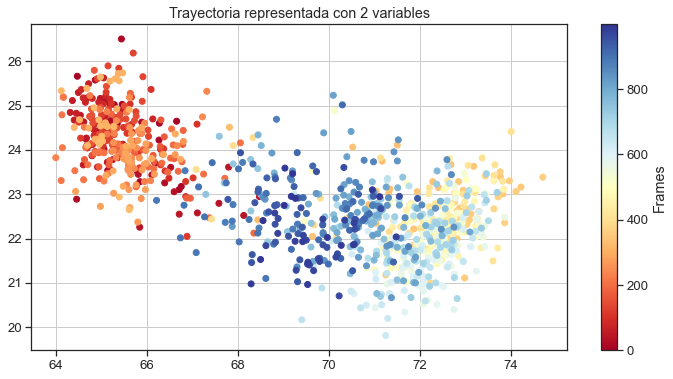

In [77]:
# Graficamos
cm = plt.cm.get_cmap('RdYlBu')
fig, ax = plt.subplots()
im = ax.scatter(x = mtx_ca_traj_1fin[:, 0], # variable 1
            y = mtx_ca_traj_1fin[:, 1], # variable 2
            c = range(n), # colorea según el número de frames
            cmap=cm
           )
ax.set(title='Trayectoria representada con 2 variables')
ax.grid()
fig.colorbar(im, label='Frames')
plt.show()

### Análisis de Componentes Principales con sklearn

In [78]:
# Importa la clase PCA de sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [79]:
?PCA

In [80]:
# Crea una instancia de la clase PCA
# Por ahora pediremos que conserve sólo los tres primeros componentes principales
pca_1fin = PCA(n_components=3)

In [81]:
# Ahora hay que alimentar al objeto PCA con la tabla

In [82]:
reduced_cartesian = pca_1fin.fit_transform(mtx_ca_traj_1fin)
reduced_cartesian.shape # Listo! sólo tres coordenadas

(1000, 3)

In [83]:
var_cp1, var_cp2, var_cp3 = pca_1fin.explained_variance_ratio_ * 100

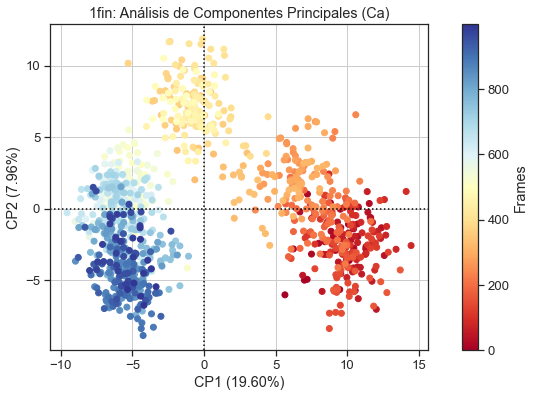

In [84]:
cm = plt.cm.get_cmap('RdYlBu')
fig, ax = plt.subplots()
im = ax.scatter(
            x = reduced_cartesian[:, 0], # variable 1
            y = reduced_cartesian[:, 1], # variable 2
            c = range(n), # colorea según el número de frames
            cmap=cm
           )
ax.set(title = '1fin: Análisis de Componentes Principales (Ca)',
       xlabel = f'CP1 ({var_cp1:.2f}%)', ylabel=f'CP2 ({var_cp2:.2f}%)')
ax.grid()
ax.axes.set_aspect(1)
ax.axhline(0, c='black', linestyle=':')
ax.axvline(0, c='black', linestyle=':')
fig.colorbar(im, label='Frames')
plt.show()

### Utilizando  `pytraj`

In [85]:
avg = pyt.mean_structure(traj_prod_1fin)
traj_prod_1fin.superpose('@CA', ref=avg)

pytraj.Trajectory, 1000 frames: 
Size: 1.016602 (GB)
<Topology: 45482 atoms, 13830 residues, 13533 mols, PBC with box type = truncoct>
           

In [86]:
pca_data = pyt.pca(traj_prod_1fin, mask='@CA', n_vecs=2)

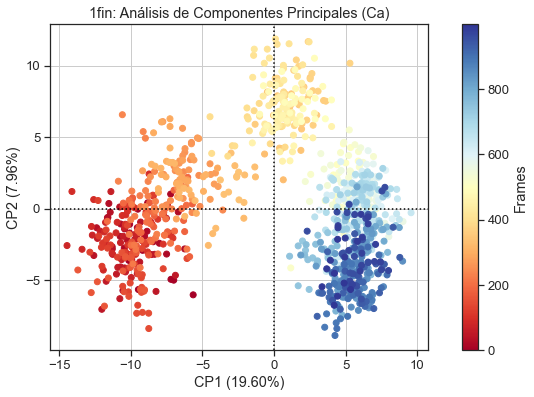

In [87]:
projection_data = pca_data[0]

cm = plt.cm.get_cmap('RdYlBu')
fig, ax = plt.subplots()
im = ax.scatter(
            x = projection_data[0], # variable 1
            y = projection_data[1], # variable 2
            c = range(n), # colorea según el número de frames
            cmap=cm
           )
ax.set(title = '1fin: Análisis de Componentes Principales (Ca)',
       xlabel = f'CP1 ({var_cp1:.2f}%)', ylabel=f'CP2 ({var_cp2:.2f}%)')
ax.grid()
ax.axes.set_aspect(1)
ax.axhline(0, c='black', linestyle=':')
ax.axvline(0, c='black', linestyle=':')
fig.colorbar(im, label='Frames')
plt.show()